<h1>TOC<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#算法链与管道" data-toc-modified-id="算法链与管道-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>算法链与管道</a></span><ul class="toc-item"><li><span><a href="#用预处理之后的数据进行参数选择" data-toc-modified-id="用预处理之后的数据进行参数选择-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>用预处理之后的数据进行参数选择</a></span></li><li><span><a href="#构建管道" data-toc-modified-id="构建管道-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>构建管道</a></span></li><li><span><a href="#在网格搜索中使用管道" data-toc-modified-id="在网格搜索中使用管道-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>在网格搜索中使用管道</a></span></li><li><span><a href="#通用管道接口" data-toc-modified-id="通用管道接口-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>通用管道接口</a></span><ul class="toc-item"><li><span><a href="#使用-'make_pipeline'创建管道" data-toc-modified-id="使用-'make_pipeline'创建管道-6.4.1"><span class="toc-item-num">6.4.1&nbsp;&nbsp;</span>使用 'make_pipeline'创建管道</a></span></li><li><span><a href="#访问步骤属性" data-toc-modified-id="访问步骤属性-6.4.2"><span class="toc-item-num">6.4.2&nbsp;&nbsp;</span>访问步骤属性</a></span></li><li><span><a href="#访问网格搜索管道中的属性" data-toc-modified-id="访问网格搜索管道中的属性-6.4.3"><span class="toc-item-num">6.4.3&nbsp;&nbsp;</span>访问网格搜索管道中的属性</a></span></li></ul></li><li><span><a href="#同时搜索预处理参数和模型参数" data-toc-modified-id="同时搜索预处理参数和模型参数-6.5"><span class="toc-item-num">6.5&nbsp;&nbsp;</span>同时搜索预处理参数和模型参数</a></span></li><li><span><a href="#通过网格搜索选择估计器类型:" data-toc-modified-id="通过网格搜索选择估计器类型:-6.6"><span class="toc-item-num">6.6&nbsp;&nbsp;</span>通过网格搜索选择估计器类型:</a></span></li><li><span><a href="#小结和展望" data-toc-modified-id="小结和展望-6.7"><span class="toc-item-num">6.7&nbsp;&nbsp;</span>小结和展望</a></span></li></ul></li></ul></div>

In [32]:
import mglearn
import sklearn
import brtoz.brmagic
import numpy as np
import matplotlib as plt
%matplotlib inline
%precision 2

'%.2f'

# 算法链与管道

使用MinMaxScaler缩放cancer数据集并用核SVM构建模型:

In [33]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 数据加载和划分
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
                                    cancer.data, cancer.target, random_state=0)

# 构建最值尺缩放器
scaler = MinMaxScaler().fit(X_train)

# 使用缩放器进行数据变换
X_train_scaled = scaler.transform(X_train)

# 使用SVC构建模型
svm = SVC()
svm.fit(X_train_scaled, y_train)

# 评估模型
X_test_scaled = scaler.transform(X_test)
print("Test score: {:.2f}".format(svm.score(X_test_scaled, y_test)))

Test score: 0.95


## 用预处理之后的数据进行参数选择

利用缩放后的数据对SVC参数进行网格搜索:

In [34]:
# 找出代码中存在的错误
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)
print("Test set accuracy: {:.2f}".format(grid.score(X_test_scaled, y_test)))

Best cross-validation accuracy: 0.98
Best parameters:  {'C': 1, 'gamma': 1}
Test set accuracy: 0.97


>上述代码的错误在于:     
* `scaler fit`的数据集范围是第一次划分的`训验集`(正确的话, 还要再分为训练集和验证集才行);
* 先进行的数据划分, 后进行的交叉验证, 导致`交叉验证的测试集`(验证集)失去了新颖性;    


`先缩放后验证`时, `数据块`的使用情况:

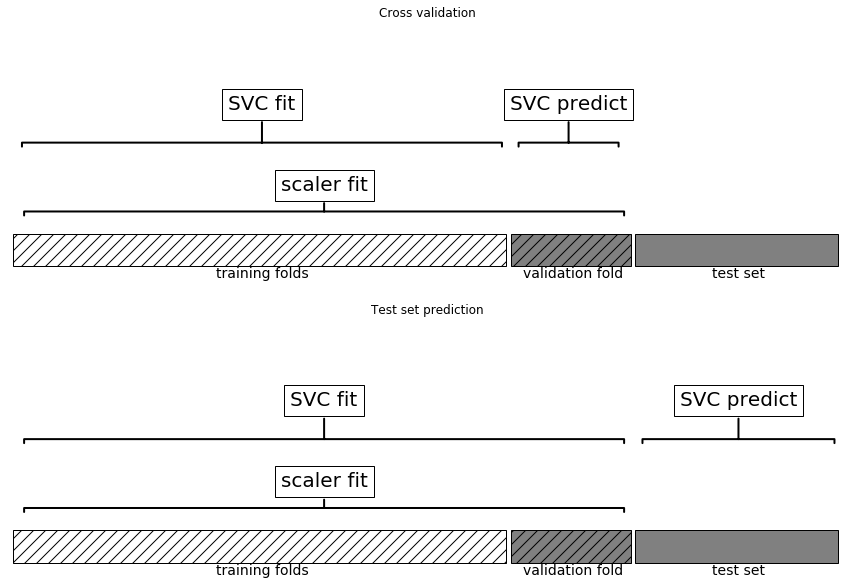

In [35]:
mglearn.plots.plot_improper_processing()

> `training folds`与`test set`经过预处理之后, 两者之间的最大值最小值是不同的, 因此`test set`可用于评估模型的性能(新颖性), 但是`validation fold`与`training folds`中的最大值和最小值是完全相同的, 因此validation失去了新颖性, 不能用于评估模型; 

> 数据预处理的过程只能放在交叉验证之后执行;   
* 管道可以将所有的数据预处理过程嵌入到交叉验证之中执行
* 使用管道之后, 可以让数据缩放步骤位于交叉验证之后(中)进行, 并且不会影响到GSCV()进行网格搜索; 有点像将scaler插入到CV和GS之间的感觉; 可认为GSCV算法的第一步操作永远是交叉验证, 然后才是数据缩放, 特征提取, 特征选择和参数选择;  

## 构建管道

**Pipeline类**提供了将多个`处理步骤`合并为单个估计器的方法;

如何使用管道:  
1. `管道对象`的实质其实就是一个`步骤列表`;
    * 步骤列表中的每个元素都是一个元组, 元组由`估计器实例`, 和`估计器`组成;  
    * 步骤列表创建之后, 保存在pipe对象的`steps属性`当中;
2. 管道对象具有一般估计器对象的fit(至少), predict和score方法;  

使用管道可以精简程序:

In [36]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])
pipe.fit(X_train, y_train)
print("Test score: {:.2f}".format(pipe.score(X_test, y_test)))

Test score: 0.95


> **预处理与监督模型组合形成的管道**

> pipe.fit(X_train, y_train):
1. 对第一个估计器调用fit: scaler.fit(X_train, y_train);   
2. 自动调用第一个估计器的transform变换: scaler.transform(X_train);  
    * X_train -> X_trian_scled
3. 对第二个估计器调用fit: svm.fit(X_train_scaled, y_train);

> pipe.score(X_test, y_test):  
1. 自动调用第一个估计器的transform变换: scaler.transform(X_test);  
2. 调用第二个估计器的score方法: svm.score(X_test_scaled, y_test)

## 在网格搜索中使用管道

当GSCV的第一个参数是管道时: `调参字典`或者`调参列表中字典的键必须含有步骤名前缀:

In [37]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

将管道pipe作为参数传递给GSCV(网格搜索类):

In [38]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.2f}".format(grid.best_score_))
print("Test set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.98
Test set score: 0.97
Best parameters: {'svm__C': 1, 'svm__gamma': 1}


使用管道时, 数据的预处理步骤肯定会在`交叉验证`内部进行:

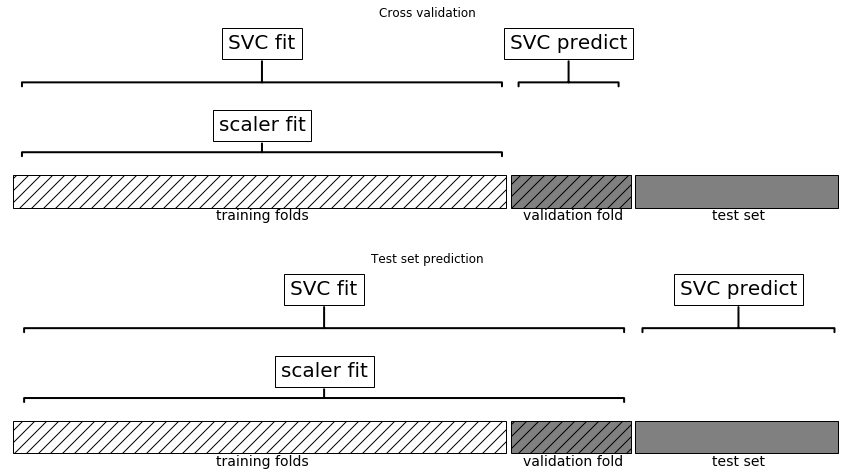

In [39]:
mglearn.plots.plot_proper_processing()

> 如果scaler fit的范围是training folds和validation fold, 将导致validation fold信息的泄露, validation就不能用于模型评估了;  
* 这种信息泄露(测试集信息`泄漏在数据缩放过程中`)通常不会产生可怕的影响;  
* 但是, 如果测试集信息泄漏在`特征提取和特征选择`中的话, 将会使结果发生巨大变化;

演示信息泄露的严重性:

In [40]:
# 创建一个不可能学到任何内容的数据集,X与y之间没有任何联系
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))

# 使用错误的预处理方式, 为分类问题选择5%的特征
from sklearn.feature_selection import SelectPercentile, f_regression
select = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y)
X_selected = select.transform(X)
print("X_selected.shape: {}".format(X_selected.shape))

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
print("Cross-validation accuracy (cv only on ridge): {:.2f}".format(
                  np.mean(cross_val_score(Ridge(), X_selected, y, cv=5))))

X_selected.shape: (100, 500)
Cross-validation accuracy (cv only on ridge): 0.91


> 交叉验证计算得到的平均分为0.91, 这表明这是一个非常好的模型, 然而这显然是有悖常识的, 因为我们的数据集中X与y之间根本没有任何联系;    
问题的来源就是因为测试集信息的泄露, 导致结果得到非常不切实际的结果;

In [41]:
# 使用管道来创建正确的数据预处理过程
pipe = Pipeline([("select", SelectPercentile(score_func=f_regression,percentile=5)),
                 ("ridge", Ridge())])
print("Cross-validation accuracy (pipeline): {:.2f}".format(
                              np.mean(cross_val_score(pipe, X, y, cv=5))))

Cross-validation accuracy (pipeline): -0.25


> 负的$R^2$分数表明该模型是一个很糟糕的模型;  


## 通用管道接口

**管道**可以将任意数量(总4?)的**估计器连接**在一起:  
* 特征提取, 特征选择, 数据缩放, 分类器(回归, 聚类);  
* 创建管道的目的主要在于, 就是将管道作为参数传递给GSCV;

**分类器可通过管道进行连接的条件**:    
* 位于管道最后一步的估计器必须有fit方法, 前面的管道必须同时有fit和transform方法;  
* 通过git和transform实现了数据的连续处理;

**pipe的内部过程**:  
从第一个估计器开始, 依次调用估计器的fit方法, 并通过的估计器transform方法给出的输出, 作为下一个估计器的输入, 最终将经过一系列变换的`输出流`传递给最后一个估计器的fit方法;  
GSCV实例本身可当做实际模型进行应用;


管道的内部结构:

In [42]:
def fit(self, X, y):
    X_transformed = X
   
    # 遍历除最后一步之外的所有步骤
    for name, estimator in self.steps[:-1]:
        # 对原始数据进行一系列的变换
        X_transformed = estimator.fit_transform(X_transformed, y)
    
    # 对最后一步进行拟合
    self.steps[-1][1].fit(X_transformed, y)
    return self

In [43]:
def predict(self, X):
    X_transformed = X
    
    # 遍历除最后一步之外的所有步骤
    for step in self.steps[:-1]:
        # 对原始数据进行一系列的变换
        X_transformed = step[1].transform(X_transformed)
    
    # 使用最后一步进行预测
    return self.steps[-1][1].predict(X_transformed)

管道内部算法的图示:

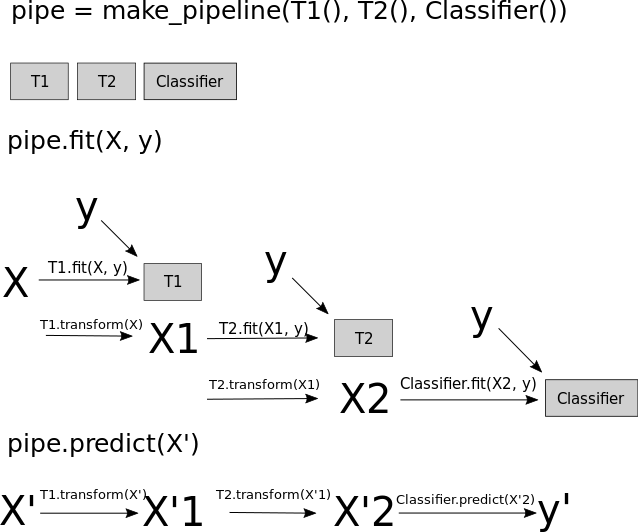

> * 从第一个估计器开始, 依次调用估计器的fit方法, 并通过估计器transform方法的输出, 为下一个估计器提供输入, 最终将输出流传递给最后一个估计器的fit方法;  
> * 调用pipe的predict方法实际上是调用最后一个估计器的predict方法, 但是在调用之前, 其参数通过`管道流`进行一系列的数据变换;

### 使用 'make_pipeline'创建管道

**make_pipeline**创建管道时, 可以根据`估计器的类别`自动为其创建`实例`(实例化之后的对象名);  
make_pipeline创建管道时, 可以只提`供估计器的类别名`作为参数; 

In [44]:
from sklearn.pipeline import make_pipeline
# 创建管道的标准语法
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
# 创建管道的简化语法
pipe_short = make_pipeline( MinMaxScaler(), SVC(C=100) )

In [45]:
%A pipe_short.steps

                            pipe_short.steps                            
------------------------------------------------------------------------
[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))),       
 ('svc', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,       
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,  
    tol=0.001, verbose=False))]                                         


In [46]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
%A pipe.steps

                                pipe.steps                                
--------------------------------------------------------------------------
[('standardscaler-1',                                                     
  StandardScaler(copy=True, with_mean=True, with_std=True)),              
 ('pca',                                                                  
  PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)),                           
 ('standardscaler-2',                                                     
  StandardScaler(copy=True, with_mean=True, with_std=True))]              


>根据类名的小写形式创建实例名, 类名相同时附加数字进行区分;

### 访问步骤属性

使用**pipe.named_steps属性**查看管道中`某一步骤估计器`的属性:  
named_steps返回一个字典, 字典的键是步骤名, 字典的值是估计器;

In [47]:
pipe.named_steps

{'standardscaler-1': StandardScaler(copy=True, with_mean=True, with_std=True),
 'pca': PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
   svd_solver='auto', tol=0.0, whiten=False),
 'standardscaler-2': StandardScaler(copy=True, with_mean=True, with_std=True)}

In [48]:
# 用上例中的管道对cancer数据集进行拟合
pipe.fit(cancer.data)
# 查看pca提取的前两个主成分
components = pipe.named_steps["pca"].components_
print("components.shape: {}".format(components.shape))

components.shape: (2, 30)


### 访问网格搜索管道中的属性

在cancer数据集上使用标准尺缩放数据, 使用逻辑回归模型拟合数据, 两者通过管道进行连接, 并使用网格搜索进行参数选择:

In [49]:
from sklearn.linear_model import LogisticRegression
pipe = make_pipeline(StandardScaler(), LogisticRegression())

# 指定网格搜索用的调参字典, 必须以步骤名作为参数名的前缀
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

# 网格搜索之前的数据划分
X_train, X_test, y_train, y_test = train_test_split(
                                cancer.data, cancer.target, random_state=4)
# 将管道作为参数, 传递给GSCV类, 然后拟合
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

使用**grid.best_estimator_属性**查看GSCV找到的最佳模型: 

In [50]:
print("Best estimator:\n\n{}".format(grid.best_estimator_))

Best estimator:

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])


上例显示最佳模型是一个管道, 可以通过named_steps属性继续访问logisticregression步骤:

In [51]:
print("Logistic regression step:\n\n{}".format(
                  grid.best_estimator_.named_steps["logisticregression"]))

Logistic regression step:

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


通过属性链查看逻辑回归模型的系数:

In [52]:
%A grid.best_estimator_.named_steps["logisticregression"].coef_

      grid.best_estimator_.named_steps["logisticregression"].coef_      
------------------------------------------------------------------------
[[-0.39, -0.38, -0.38, -0.4 , -0.12,  0.02, -0.36, -0.39, -0.06,  0.21, 
  -0.49, -0.  , -0.37, -0.38, -0.04,  0.2 ,  0.  , -0.05,  0.21,  0.22, 
  -0.55, -0.53, -0.5 , -0.51, -0.39, -0.12, -0.39, -0.42, -0.33, -0.14]]


## 同时搜索预处理参数和模型参数

创建包含三个步骤的管道: 缩放数据, 计算多项式特征, 岭回归;  
通过管道可以同时调节关于`特征选择(degree)`步骤和`模型构建(C)`步骤中的参数;

In [53]:
from sklearn.datasets import load_boston
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target,
                                                    random_state=0)
from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), Ridge())

In [54]:
# 同时设置多个步骤中的调参范围, 参数名由步骤名作为前缀
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

In [55]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train) 

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'polynomialfeatures__degree': [1, 2, 3], 'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

将交叉验证的结果可视化:  

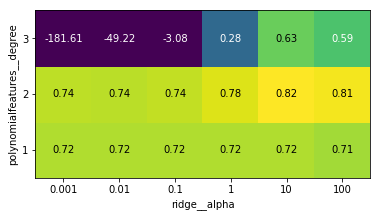

In [56]:
mglearn.tools.heatmap(grid.cv_results_['mean_test_score'].reshape(3, -1),
                      xlabel="ridge__alpha", ylabel="polynomialfeatures__degree",
                      xticklabels=param_grid['ridge__alpha'],
                      yticklabels=param_grid['polynomialfeatures__degree'], vmin=0)

> * 说是将交叉验证的结果可视化, 其实是将所有参数组合的得分情况可视化, 因为参数的得分情况就是以`5次交叉验证的平均精度`作为指标的;  
* 调参范围的所有组合, 完全可由调参字典的结构给出;  
* 不必纠结交叉验证和网格搜索的概念; 

模型的最佳参数和最佳性能:

In [57]:
print("Best parameters: {}".format(grid.best_params_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Best parameters: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}
Test-set score: 0.77


对比一个没有多项式特征的网格搜索:

In [58]:
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Score without poly features: {:.2f}".format(grid.score(X_test, y_test)))

Score without poly features: 0.63


## 通过网格搜索选择估计器类型:

如果把管道中的`模型类别`(KNN,SVC,Ridge..)或者`缩放器类别`(标准尺, 最值尺,归一尺)作为一种管道参数的话, **网格搜索**也能搜索管道步骤中**估计器的类型**;  

在iris数据集上比较随机森林模型和SVC模型:

> 模型步骤有两种可能:  
SVC模型: 有参数C和Gamma;  
RFC模型: 有参数max_feature

> 预处理步骤有两种可能:    
使用StandScaler进行数据缩放: 没有参数;  
不进行数据缩放: 没有参数;  

> 两个步骤之间的联系: 
SVM需要数据缩放, RFC不需要数据缩放;  

定义一个连接缩放器和分类器的管道, 使用StandScaler实例化缩放器, 使用SVC实例化分类器:

In [59]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

建立GSCV类的调参列表:

In [60]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [
    
    {'classifier': [SVC()],
     
     'preprocessing': [StandardScaler(), None],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    
    {'classifier': [RandomForestClassifier(n_estimators=100)],
     
     'preprocessing': [None], 
     'classifier__max_features': [1, 2, 3]}     ]

> 1. `调参序列`中`调参字典`的个数, 并不是与管道中每个步骤的估计器对应, 而是与所有参数组合的一种`分裂形式`对应, 每个调参字典都是全空间(所有参数组合)搜索的一个子集, `调参序列`中调参字典的并集是全网格搜索空间的一个`等效子集`, 就是前面提到过的`在非网格的空间中搜索`;
2. 管道中某一步的估计器类型作为一种参数时, 其在调参字典中的等级与普通的模型参数相同;   

> 1. 在非网格空间中搜索参数: 
    * SVC模型要调节三个参数, 总的参数组合应当是2*6*6=72种, 因为有些参数组合没有必要(参数`kernel`=`linear`时, 不会用到参数gamma), 所以全空间的参数字典要进行等效分裂;     * 普通模型中调参字典的分裂, 按`可取值最少的`参数进行分裂, 如`kernel`;    
    * 单估计器`调三参`时的调参序列:   
    `param_grid_svc = [{'kernel': ['rbf'],'C': [1, 10, 100],'gamma': [1, 10, 100]},` `{'kernel': ['linear'],'C': [1, 10, 100]}]`
2. 上例中估计器类型也作为参数时, 总计五种参数(模型类别两个, 缩放器两个, 分类器gamma六种, 分类器C六种, 分类器最大特征三种, 总2*2*6*6*3=432种参数组合);  但是RFC模型不需要进行缩放处理, 所以全空间搜索要进行分裂;  
    * `多估计器`调多参时的调参字典按`模型种类`进行分裂, 如`classifier`;   


In [61]:
X_train, X_test, y_train, y_test = train_test_split(
                        cancer.data, cancer.target, random_state=0)

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))

Best params:
{'classifier': SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

Best cross-validation score: 0.99
Test-set score: 0.98


## 小结和展望

简述管道的工作原理;  
描述调参字典的结构;